In [16]:
import xml.etree.ElementTree as ET
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    folder = root.find('folder').text
    filename = root.find('filename').text
    label = root.find('object').find('name').text
    
    bndbox = root.find('object').find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    
    return folder, filename, label, (xmin, ymin, xmax, ymax)

class DogBreedDataset(Dataset):
    def __init__(self, annotations_dir, images_dir, label_map, transform=None):
        self.annotations_dir = annotations_dir
        self.images_dir = images_dir
        self.transform = transform
        self.label_map = label_map
        self.data = self._load_data()

    def _load_data(self):
        data = []
        for subfolder in os.listdir(self.annotations_dir):
            for xml_file in os.listdir(os.path.join(self.annotations_dir, subfolder)):
                xml_path = os.path.join(self.annotations_dir, subfolder, xml_file)
                folder, filename, label, bbox = parse_annotation(xml_path)
                img_path = os.path.join(self.images_dir, subfolder, xml_file)
                label_idx = self.label_map[label]
                data.append((img_path, label_idx, bbox))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label_idx, bbox = self.data[idx]
        img_path = f"{img_path}.jpg"
        
        # Detect image format and open image
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert("RGB")
        
        # Crop the image using the bounding box
        xmin, ymin, xmax, ymax = bbox
        image = image.crop((xmin, ymin, xmax, ymax))
    
        # One-hot encode the label
        label = torch.zeros(len(self.label_map))
        label[label_idx] = 1

        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
num_classes = 120  # Replace with the actual number of dog breeds
data_folder = "C:\\bccn\programming\data"
images_dir = os.path.join(data_folder, 'images')
annotations_dir = os.path.join(data_folder, 'Annotation')

all_labels = []
for subfolder in os.listdir(annotations_dir):
    all_labels.append(subfolder[10:])

label_map = {breed: idx for idx, breed in enumerate(all_labels)}

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = DogBreedDataset(annotations_dir, images_dir, label_map, transform=transform)

#create full dataloader
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

#train test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#create train and test dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [22]:
#transer learning model import
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)
# Freeze all layers except the first and last
for name, param in model.named_parameters():
    if 'layer4.2' not in name and 'fc' not in name:
        param.requires_grad = False

Using device: cuda


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

        print(f"Test loss: {running_loss/len(test_dataloader):.4f}")


print("Training complete.")

Epoch [1/10], Loss: 0.5769
Test loss: 0.6469
Epoch [2/10], Loss: 0.3291


In [16]:
model = torch.load("dog_breed_classifier.pth").to(device)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = DogBreedDataset(annotations_dir, images_dir, label_map, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: ['Walker_hound' 'Pekinese' 'Saluki' 'Staffordshire_bullterrier'
 'Japanese_spaniel' 'Maltese_dog' 'redbone' 'otterhound' 'bloodhound'
 'Afghan_hound' 'basset' 'bloodhound' 'redbone' 'Ibizan_hound'
 'Afghan_hound' 'toy_terrier']
Ground Truth: ['Walker_hound' 'Pekinese' 'Saluki' 'Staffordshire_bullterrier'
 'Japanese_spaniel' 'Maltese_dog' 'redbone' 'otterhound' 'bloodhound'
 'Afghan_hound' 'bloodhound' 'bloodhound' 'redbone' 'Ibizan_hound'
 'Afghan_hound' 'toy_terrier']


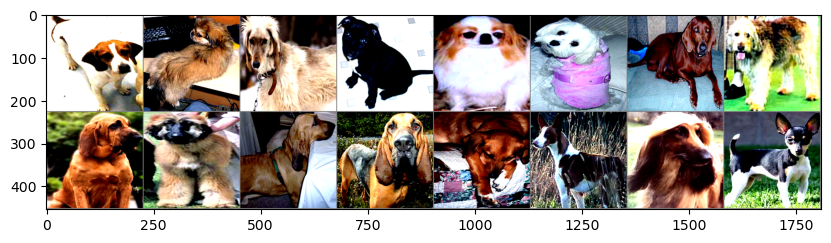

In [19]:
all_labels = np.array(all_labels)
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()
    predicted = predicted.astype(int)
    trues = np.argmax(labels.cpu().numpy(), axis = 1)
    trues = trues.astype(int)
   
    print("Predicted:", all_labels[predicted])
    print("Ground Truth:", all_labels[trues])

    #display the images
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(10, 7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    break